In [8]:
import numpy as np
import pandas as pd
import hopsworks

In [9]:
api_key = ""

project = hopsworks.login(api_key_value=api_key, project="ID2223HT24G4" )
fs = project.get_feature_store()

2025-01-06 15:57:37,857 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-06 15:57:37,870 INFO: Initializing external client
2025-01-06 15:57:37,871 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-06 15:57:39,306 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1167511


In [10]:
feature_view = fs.get_feature_view(name="rate_vix_bzf_omx_feature_view", version=1)
data = feature_view.get_batch_data()
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')

df = data.copy()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.64s) 


In [11]:


df["rate_plus_7d"] = df["rate"].shift(-7)
df["rate_plus_1d"] = df["rate"].shift(-1)
df.dropna(inplace=True)


print(df.head())

                          date    rate        vix          omx        bzf  \
313  2010-12-01 00:00:00+00:00  7.0246  21.360001  1134.270020  88.870003   
556  2010-12-02 00:00:00+00:00  6.9743  19.389999  1145.510010  90.690002   
1710 2010-12-03 00:00:00+00:00  6.9019  18.010000  1149.560059  91.419998   
3307 2010-12-06 00:00:00+00:00  6.7927  18.020000  1144.439941  91.449997   
794  2010-12-07 00:00:00+00:00  6.8525  17.990000  1148.979980  91.389999   

      rate_plus_7d  rate_plus_1d  
313         6.8926        6.9743  
556         6.9214        6.9019  
1710        6.8237        6.7927  
3307        6.8076        6.8525  
794         6.8376        6.8960  


In [12]:
train_mask = df['date'] < "2023-01-01"
val_mask   = (df["date"] >= "2023-01-01") & (df["date"] < "2024-01-01")
test_mask  = df["date"] >= "2024-01-01"

df_train = df[train_mask].copy()
df_val   = df[val_mask].copy()
df_test  = df[test_mask].copy()

FEATURE_COLS = ["rate", "vix", "omx", "bzf"]  # adapt as needed
LABEL_COL = ["rate_plus_1d", "rate_plus_7d"]


X_train = df_train[FEATURE_COLS].values
y_train = df_train[LABEL_COL].values

X_val   = df_val[FEATURE_COLS].values
y_val   = df_val[LABEL_COL].values

X_test  = df_test[FEATURE_COLS].values
y_test  = df_test[LABEL_COL].values

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:  ", X_val.shape,   y_val.shape)
print("Test shape: ", X_test.shape,  y_test.shape)


Train shape: (2918, 4) (2918, 2)
Val shape:   (243, 4) (243, 2)
Test shape:  (242, 4) (242, 2)


In [13]:
from sklearn.preprocessing import MinMaxScaler

# Scale features
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)  # fit only on train
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

# Scale labels
scaler_y = MinMaxScaler()
scaler_y.fit(y_train)  # fit on (N,2) for day+1, day+7
y_train_scaled = scaler_y.transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

print("Scaled shapes:", X_train_scaled.shape, y_train_scaled.shape)


Scaled shapes: (2918, 4) (2918, 2)


In [14]:
def create_sequences(X, Y, seq_len=30):
    """
    X: (N, num_features)
    Y: (N, 2) [day+1, day+7]
    Returns:
      X_seq: (N - seq_len, seq_len, num_features)
      Y_seq: (N - seq_len, 2)
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i : i + seq_len])          # up to i+seq_len-1
        ys.append(Y[i + seq_len - 1])   
    return np.array(Xs), np.array(ys)

sequence_length = 30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val_scaled,   sequence_length)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  sequence_length)

print("X_train_seq:", X_train_seq.shape)  # (N_train_seq, 30, 4)
print("y_train_seq:", y_train_seq.shape)  # (N_train_seq, 2)


X_train_seq: (2888, 30, 4)
y_train_seq: (2888, 2)


In [15]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

def build_model(hp):
    model = Sequential()

    # First LSTM
    model.add(Bidirectional(LSTM(
        units=hp.Int("units_lstm1", min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(sequence_length, len(FEATURE_COLS))
    )))
    model.add(Dropout(hp.Float("dropout_lstm1", 0.1, 0.5, step=0.2)))

    # Second LSTM
    model.add(LSTM(
        units=hp.Int("units_lstm2", min_value=16, max_value=64, step=16),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float("dropout_lstm2", 0.1, 0.5, step=0.2)))

    # Final output: 2 neurons -> [rate_plus_1d, rate_plus_7d]
    model.add(Dense(2))

    # Compile
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,  # for demonstration, you might use more
    directory="my_lstm_tuning",
    project_name="multi_output"
)

tuner.search(
    X_train_seq, 
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        )
    ]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best HPs:", best_hps.values)

best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_mae = best_model.evaluate(X_test_seq, y_test_seq)
print("Test Loss (MSE):", test_loss, "Test MAE:", test_mae)


Trial 5 Complete [00h 00m 13s]
val_loss: 0.0022751311771571636

Best val_loss So Far: 0.0010962375672534108
Total elapsed time: 00h 01m 58s
Best HPs: {'units_lstm1': 128, 'dropout_lstm1': 0.5, 'units_lstm2': 48, 'dropout_lstm2': 0.5, 'learning_rate': 0.007607466047144503}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - mae: 0.0274 
Test Loss (MSE): 0.0013006702065467834 Test MAE: 0.030199114233255386


In [16]:
y_pred_scaled = best_model.predict(X_test_seq)  # shape: (num_test_seq, 2)

# Inverse transform to original units
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


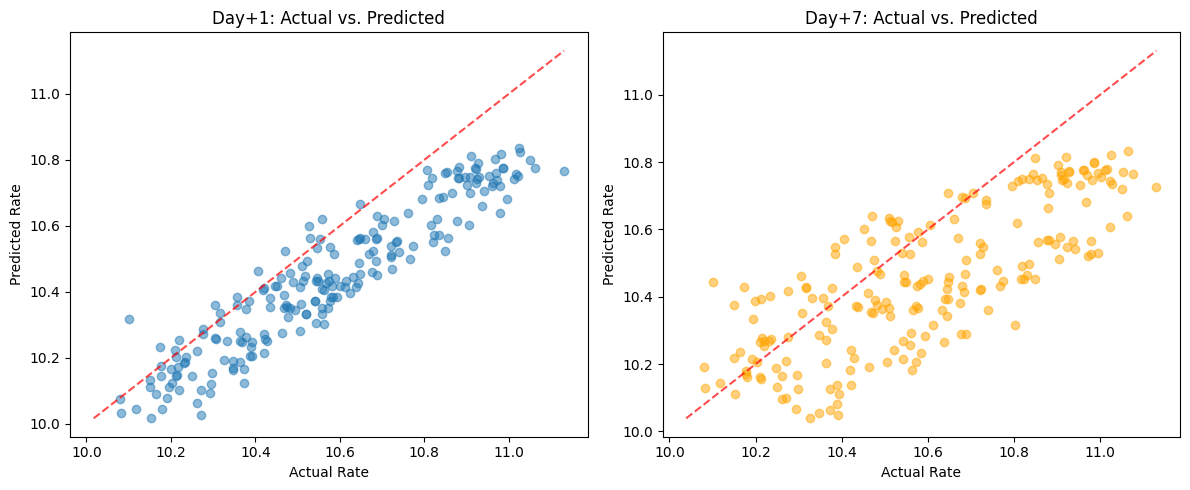

In [17]:
import matplotlib.pyplot as plt

day1_pred = y_pred[:, 0]
day1_true = y_true[:, 0]
day7_pred = y_pred[:, 1]
day7_true = y_true[:, 1]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(day1_true, day1_pred, alpha=0.5)
min_val, max_val = min(day1_true.min(), day1_pred.min()), max(day1_true.max(), day1_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
plt.title("Day+1: Actual vs. Predicted")
plt.xlabel("Actual Rate")
plt.ylabel("Predicted Rate")

plt.subplot(1,2,2)
plt.scatter(day7_true, day7_pred, alpha=0.5, color='orange')
min_val, max_val = min(day7_true.min(), day7_pred.min()), max(day7_true.max(), day7_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
plt.title("Day+7: Actual vs. Predicted")
plt.xlabel("Actual Rate")
plt.ylabel("Predicted Rate")

plt.tight_layout()
plt.show()


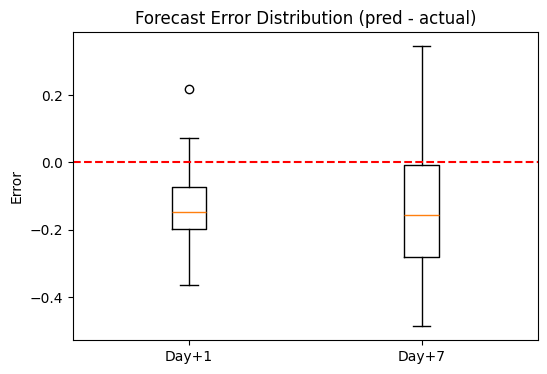

In [18]:
day1_errors = day1_pred - day1_true
day7_errors = day7_pred - day7_true

plt.figure(figsize=(6,4))
plt.boxplot([day1_errors, day7_errors], labels=["Day+1", "Day+7"])
plt.axhline(0, color='red', linestyle='--')
plt.title("Forecast Error Distribution (pred - actual)")
plt.ylabel("Error")
plt.show()


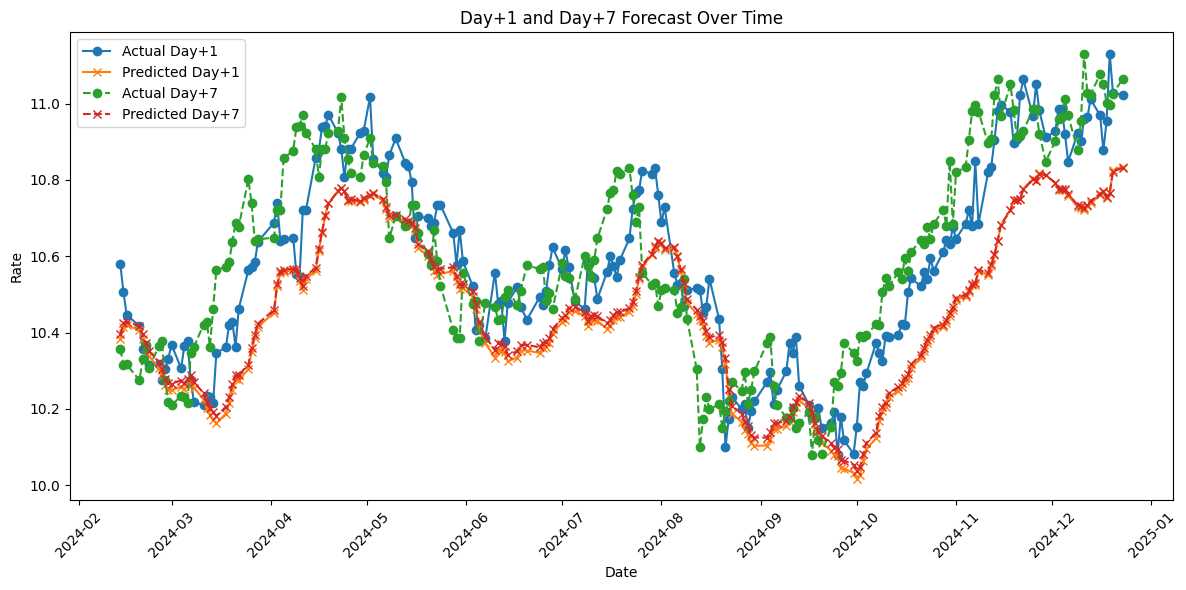

In [19]:
test_dates = df_test["date"].values  # shape (N_test,)
# But your X_test_seq has length (N_test_seq = N_test - seq_len).
# So for each i in [0 .. N_test_seq-1], the forecast date might correspond to test_dates[i + seq_len].
dates_seq = test_dates[sequence_length:]  # approximate alignment

plt.figure(figsize=(12,6))
plt.plot(dates_seq, day1_true, 'o-', label='Actual Day+1')
plt.plot(dates_seq, day1_pred, 'x-', label='Predicted Day+1')
plt.plot(dates_seq, day7_true, 'o--', label='Actual Day+7')
plt.plot(dates_seq, day7_pred, 'x--', label='Predicted Day+7')
plt.title("Day+1 and Day+7 Forecast Over Time")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
import joblib

mr = project.get_model_registry()


local_model_dir = "7day_lstm_model"
!mkdir -p $local_model_dir 

model_file = local_model_dir + "/rates_lstm_model.keras"
best_model.save(model_file)  

scaler_file_X = local_model_dir + "/scaler_x.pkl"
joblib.dump(scaler_X, scaler_file_X)

scaler_file_y = local_model_dir + "/scaler_y.pkl"
joblib.dump(scaler_y, scaler_file_y)

model_meta = mr.python.create_model(
    name="lstm_rate_vix_omx_bzf_7day",
    description="LSTM for 7-day forecast of rate and vix+omx+bzf, including scaler"
)

model_meta.save(local_model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/743 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/823 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/819036 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1167511/models/lstm_rate_vix_omx_bzf_7day/1


Model(name: 'lstm_rate_vix_omx_bzf_7day', version: 1)

Model and scaler successfully saved to Hopsworks Model Registry!
